In [2]:
import sys
sys.path.append('..')

from src.pdfs_numba_stats import SignalBackgroundModel
import numpy as np
import matplotlib.pyplot as plt

from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL

plt.style.use('mystyle.mplstyle')
np.random.seed(42)

## Parametric Bootstrapping (trial with sample size = 1000)


In [3]:
# Parameters
signal_params = {
    'mu': 3, 
    'sigma': 0.3, 
    'beta': 1, 
    'm': 1.4, 
    'decay_rate': 0.3
}
background_params = {
    'mu_bg': 0, 
    'sigma_bg': 2.5
}
f = 0.6  # Signal fraction
x_min, x_max = 0, 5
y_min, y_max = 0, 10

# Create model
model = SignalBackgroundModel(*signal_params.values(), *background_params.values(), f, x_min, x_max, y_min, y_max)

### Generate original data (from the true pdf) and Fit using EML

In [4]:
f_max = model.pdf(3, 0)
def accept_reject_sampling_2d_with_Poisson(
        pdf, 
        n_samples: int, 
        x_min: float, x_max: float, 
        y_min: float, y_max: float, 
        f_max: float, 
        random_state: np.random.RandomState = np.random.RandomState(42)
    ):
    # Possion variable on the sample size
    n_samples = np.random.poisson(n_samples)
    # Preallocate space for samples
    samples = np.zeros((n_samples, 2))
    count = 0  # Track the number of accepted samples

    # Generate samples in batches
    batch_size = int(2 * n_samples)  # Choose an appropriate batch size
    while count < n_samples:
        # Generate a batch of candidate points
        x = np.random.uniform(low=x_min, high=x_max, size=batch_size)
        y = np.random.uniform(low=y_min, high=y_max, size=batch_size)
        u = np.random.uniform(low=0, high=f_max, size=batch_size)

        # Evaluate the PDF
        pdf_values = pdf(x, y)

        # Accept samples
        accepted = u < pdf_values
        n_accepted = np.sum(accepted)

        # Limit the number of accepted samples to the remaining capacity
        remaining_capacity = n_samples - count
        n_to_add = min(n_accepted, remaining_capacity)

        # Add only as many samples as fit in the remaining capacity
        samples[count:count + n_to_add] = np.column_stack((x[accepted], y[accepted]))[:n_to_add]
        count += n_to_add

    return samples[:n_samples]

samples = accept_reject_sampling_2d_with_Poisson(model.pdf, 1000, x_min, x_max, y_min, y_max, f_max)

In [5]:
# Define the total density function
def total_density(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    return N * SignalBackgroundModel.sb_pdf(
        mu, sigma, beta, m, decay_rate,
        mu_bg, sigma_bg, f,
        xy[0, :], xy[1, :],
        x_min, x_max, y_min, y_max
    )

def extended_total_density(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    return N, total_density(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f)

# Fit the model to the data
NLL_unbinned = ExtendedUnbinnedNLL(data=samples.T, scaled_pdf=extended_total_density)
mi_0 = Minuit(NLL_unbinned, N=1000,
           mu=3, sigma=0.3, beta=1, m=1.4, decay_rate=0.3, 
           mu_bg=0, sigma_bg=2.5, f=0.6)
mi_0.migrad()
print(mi_0.values)
print(mi_0.errors)

<ValueView N=987.954008426945 mu=2.980506243754832 sigma=0.28264280036892514 beta=0.6858503939322996 m=3.818721238784625 decay_rate=0.3004452216791042 mu_bg=-0.9904452630243205 sigma_bg=3.123549045706505 f=0.556828222974999>
<ErrorView N=31.20808364457299 mu=0.03877225979845899 sigma=0.029311737954981796 beta=0.23301501177300613 m=3.598246655566922 decay_rate=0.020967440823260308 mu_bg=1.4395540281209538 sigma_bg=0.5683895214239352 f=0.03656342679956958>


### Bootstrap & Fit back with the model

In [6]:
from resample import bootstrap
import tqdm

boot_samples = np.array( [ b for b in bootstrap.resample(samples, size=250) ] )
print(boot_samples.shape)

(250, 988, 2)


In [7]:
# fit each of these pseudo-experiments back with the model (using EML)
values = []
errors = []

for i in tqdm.tqdm(range(boot_samples.shape[0])):
    NLL_unbinned = ExtendedUnbinnedNLL(data=boot_samples[i].T, scaled_pdf=extended_total_density)
    mi = Minuit(NLL_unbinned, N=1000, 
               mu=3, sigma=0.3, beta=1, m=1.4, decay_rate=0.3, 
               mu_bg=0, sigma_bg=2.5, f=0.6)
    mi.migrad()
    values.append(mi.values)
    errors.append(mi.errors)

values = np.array(values)
truth = np.array(list(mi_0.values))
print(truth.shape)
errors = np.array(errors)
pulls = (values - truth) / errors

print(values.shape)

 31%|███       | 77/250 [00:13<00:34,  4.95it/s]/Users/clementine/mphildis/coursework/S1/xl628/notebooks/../src/pdfs_numba_stats.py:67: RuntimeWarning: invalid value encountered in divide
  return self.pdf(x) / self.normalization
100%|██████████| 250/250 [00:34<00:00,  7.16it/s]

(9,)
(250, 9)


In [8]:
# Calculate the bias
lambda_values = values[:, 5]
lambda_truth = truth[5]
lambda_errors = errors[:, 5]
lambda_pulls = (lambda_values - lambda_truth) / lambda_errors

# Calculate the mean and standard deviation of the values, uncertainties and pulls
lambda_values_mean = np.mean(lambda_values)
lambda_values_std = np.std(lambda_values)
lambda_errors_mean = np.nanmean(lambda_errors)
lambda_errors_std = np.nanstd(lambda_errors)
lambda_pulls_mean = np.nanmean(lambda_pulls)
lambda_pulls_std = np.nanstd(lambda_pulls)

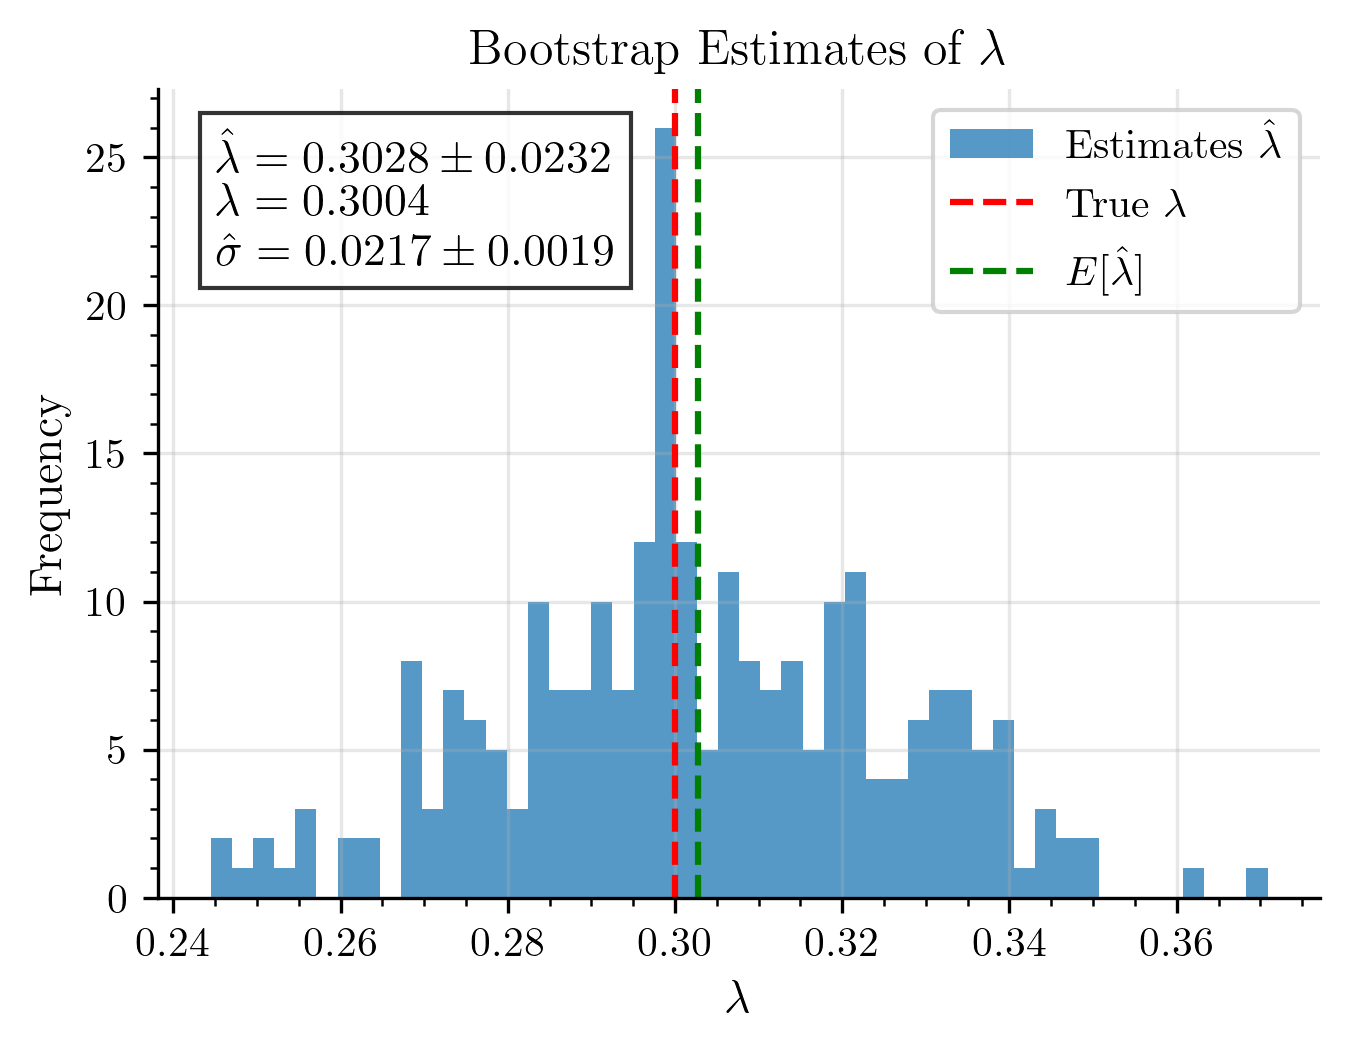

In [9]:
plt.figure()
plt.hist(lambda_values, bins=50, alpha=0.75, label='Estimates $\hat{\lambda}$')
plt.axvline(x=signal_params['decay_rate'], color='red', linestyle='--', label='True $\lambda$')
plt.axvline(x=lambda_values_mean, color='green', linestyle='--', label='$E[\hat{\lambda}]$')
plt.text(0.05, 0.95, 
         f'$\hat{{\lambda}} = {lambda_values_mean:.4f} \pm {lambda_values_std:.4f}$' +
         f'\n $\lambda = {lambda_truth:.4f}$' +
         f'\n $\hat{{\sigma}} = {lambda_errors_mean:.4f} \pm {lambda_errors_std:.4f}$',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('$\lambda$')
plt.ylabel('Frequency')
plt.title('Bootstrap Estimates of $\lambda$')
plt.legend()
plt.savefig('../report/images/bootstrap_estimates.pdf', bbox_inches='tight')
plt.show()


## Parametric Bootstrapping (Various sample sizes)

In [10]:
sample_sizes = [500, 1000, 2500, 5000, 10000]
results = {
    'sample_size': [],
    'estimates': [],
    'estimates_std': [],
    'uncertainties': [],
    'uncertainties_std': [],
    'truth': []
}

all_samples = {}
for sample_size in sample_sizes:
    samples = accept_reject_sampling_2d_with_Poisson(model.pdf, sample_size, x_min, x_max, y_min, y_max, f_max)
    all_samples[sample_size] = samples

# Save the samples to a file
np.save('all_samples.npy', all_samples)

In [11]:
# 5 minutes on my laptop
for sample_size in sample_sizes:
    # Generate the data
    samples = all_samples[sample_size]
    # Fit the model to the data
    NLL_unbinned = ExtendedUnbinnedNLL(data=samples.T, scaled_pdf=extended_total_density)
    mi_0 = Minuit(NLL_unbinned, N=sample_size,
               mu=3, sigma=0.3, beta=1, m=1.4, decay_rate=0.3, 
               mu_bg=0, sigma_bg=2.5, f=0.6)
    mi_0.migrad()
    results['truth'].append(mi_0.values[5]) # Store the truth

    # Bootstrap the data and fit the model to each bootstrap sample
    boot_samples = np.array( [ b for b in bootstrap.resample(samples, size=250) ] )
    values = []
    errors = []
    for i in tqdm.tqdm(range(boot_samples.shape[0])):
        NLL_unbinned = ExtendedUnbinnedNLL(data=boot_samples[i].T, scaled_pdf=extended_total_density)
        mi = Minuit(NLL_unbinned, N=sample_size, 
                   mu=3, sigma=0.3, beta=1, m=1.4, decay_rate=0.3, 
                   mu_bg=0, sigma_bg=2.5, f=0.6)
        mi.migrad()
        values.append(mi.values)
        errors.append(mi.errors)

    values = np.array(values)
    truth = np.array(list(mi_0.values))
    errors = np.array(errors)
    # pulls = (values - truth) / errors # contains inf

    lambda_values = values[:, 5]
    lambda_errors = errors[:, 5]

    # Calculate the mean and standard deviation of the values and uncertainties
    lambda_values_mean = np.mean(lambda_values)
    lambda_values_std = np.std(lambda_values)
    lambda_errors_mean = np.nanmean(lambda_errors)
    lambda_errors_std = np.nanstd(lambda_errors)

    results['sample_size'].append(sample_size)
    results['estimates'].append(lambda_values_mean)
    results['estimates_std'].append(lambda_values_std)
    results['uncertainties'].append(lambda_errors_mean)
    results['uncertainties_std'].append(lambda_errors_std)


 21%|██        | 52/250 [00:06<00:16, 11.93it/s]/Users/clementine/mphildis/coursework/S1/xl628/notebooks/../src/pdfs_numba_stats.py:67: RuntimeWarning: invalid value encountered in divide
  return self.pdf(x) / self.normalization
 99%|█████████▉| 248/250 [00:35<00:00, 11.30it/s]/Users/clementine/mphildis/coursework/S1/xl628/notebooks/../src/pdfs_numba_stats.py:37: RuntimeWarning: divide by zero encountered in divide
  return self.pdf(x) / self.normalization
/Users/clementine/mphildis/coursework/S1/xl628/notebooks/../src/pdfs_numba_stats.py:99: RuntimeWarning: divide by zero encountered in divide
  return self.pdf(x) / self.normalization
100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


In [12]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv('bootstrap_results.csv', index=False)
results_df

,sample_size,estimates,estimates_std,uncertainties,uncertainties_std,truth
0,500,0.281632,0.026388,0.028621,0.002450,0.277990
1,1000,0.329699,0.023122,0.021276,0.001943,0.328058
2,2500,0.295903,0.012576,0.012663,0.000448,0.295615
3,5000,0.275563,0.011053,0.009112,0.000235,0.274368
4,10000,0.295914,0.006200,0.006409,0.000127,0.295871


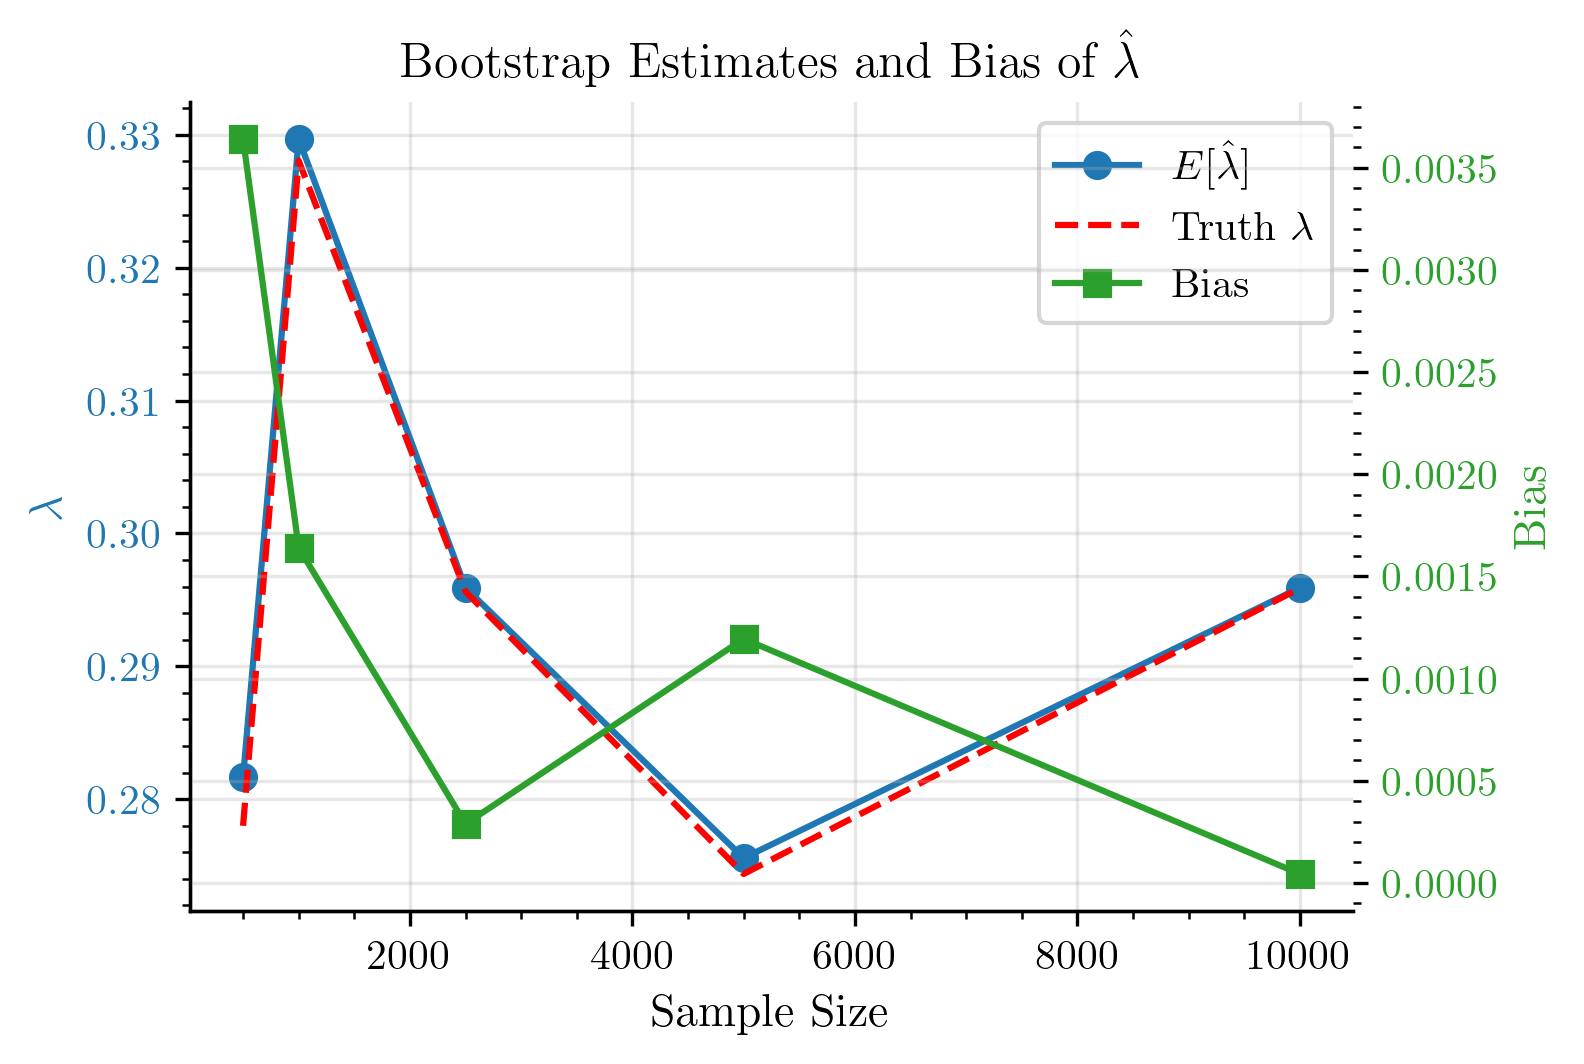

In [16]:
fig, ax1 = plt.subplots()
color1 = 'tab:blue'
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('$\lambda$', color=color1)
ax1.plot(results_df['sample_size'], results_df['estimates'], '-o', color=color1, label='$E[\hat{\lambda}]$')
ax1.plot(results_df['sample_size'], results_df['truth'], color='red', linestyle='--', label='Truth $\lambda$')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Bias', color=color2)
bias = results_df['estimates'] - results_df['truth']
ax2.plot(results_df['sample_size'], bias, '-s', color=color2, label='Bias')
ax2.tick_params(axis='y', labelcolor=color2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Bootstrap Estimates and Bias of $\hat{\lambda}$')
plt.savefig('../report/images/bootstrap_sizes_estimates_with_bias.pdf', bbox_inches='tight')
plt.show()

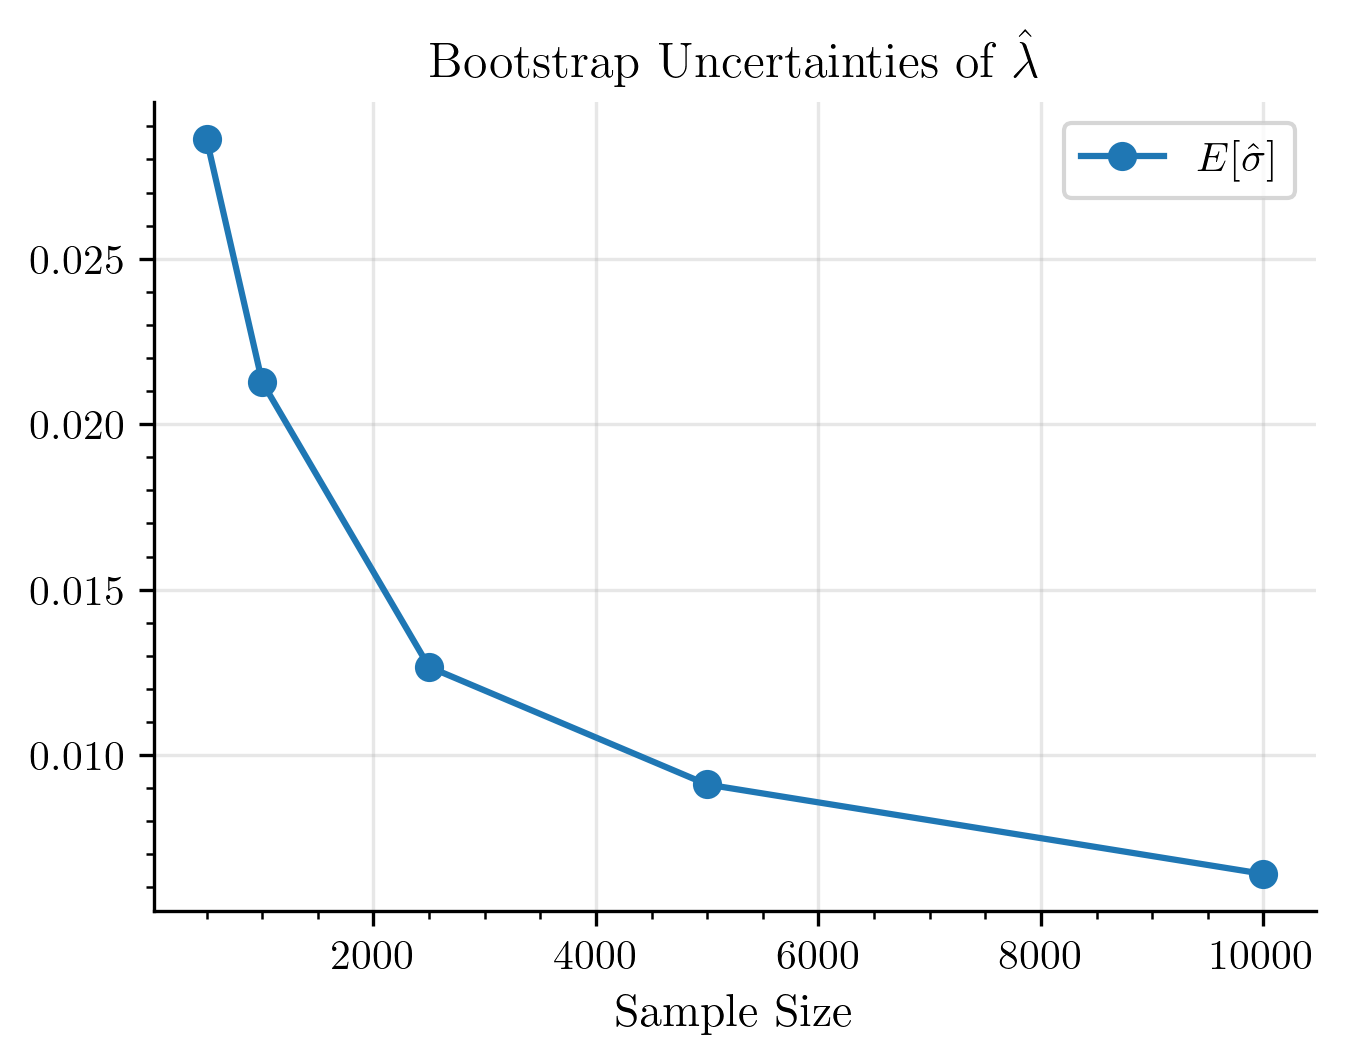

In [17]:
plt.figure()
plt.plot(results_df['sample_size'], results_df['uncertainties'], '-o', label='$E[\hat{\sigma}]$')
plt.xlabel('Sample Size')
plt.title('Bootstrap Uncertainties of $\hat{\lambda}$')
plt.legend()
plt.savefig('../report/images/bootstrap_sizes_uncertainties.pdf', bbox_inches='tight')
plt.show()